HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Описание столбцов:
* work_year	Год, в котором была выплачена зарплата.
* experience_level	Опыт работы на этой должности в течение года со следующими возможными значениями:
  * EN — Entry-level/Junior;
  * MI — Mid-level/Intermediate;
  * SE — Senior-level/Expert;
  * EX — Executive-level/Director.
  
* employment_type	Тип трудоустройства для этой роли:
  * PT — неполный рабочий день;
  * FT — полный рабочий день;
  * CT — контракт;
  * FL — фриланс.

* job_title -	Роль, в которой соискатель работал в течение года.
* salary -	Общая выплаченная валовая сумма заработной платы.
* salary_currency -	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd -	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence -	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio -	Общий объём работы, выполняемой удалённо. Возможные значения:
  * 0 — удалённой работы нет (менее 20 %);
  * 50 — частично удалённая работа;
  * 100 — полностью удалённая работа (более 80 %).
* company_location -	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size -	Среднее количество людей, работавших в компании в течение года:
  * S — менее 50 сотрудников (небольшая компания);
  * M — от 50 до 250 сотрудников (средняя компания);
  * L — более 250 сотрудников (крупная компания).

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
  * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
  * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
  * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
  * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## Загрузка данных

In [500]:
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

Данные скопированы в Google Drive  и доступны по [ссылке](https://drive.google.com/file/d/1NGgdLzaQqVu0DQJzVl1Sbva64khF5qkv/view?usp=sharing)

In [501]:
original_data=pd.read_csv('project_data\ds_salaries.csv',index_col='Unnamed: 0')
data=original_data.copy()
display(data.columns)
data.head(3)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M


In [502]:
# задаем уровень значимости
alpha= 0.05
print('Уровень значимости aplha = {:.2f}'.format(alpha))

Уровень значимости aplha = 0.05


## Описательный анализ данных

In [503]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В талице 607 записей (без пропущенных значений).

Проверим дубликаты

In [504]:
print('Общий размер таблицы: {}'.format(data.shape))
print('Количество дубликатов в таблице: {}'.format(data[data.duplicated()].shape[0]))
data=data.drop_duplicates()
print('Новый размер таблицы после удаления дубликатов: {}'.format(data.shape))


Общий размер таблицы: (607, 11)
Количество дубликатов в таблице: 42
Новый размер таблицы после удаления дубликатов: (565, 11)


Удалим неинформативные признаки такие как:
- "salary";
- "salary_currency".
Заработные платы приведены к одной валюте в колонке 'salary_in_usd'.

In [505]:
del data['salary']
del data['salary_currency']

Для изучения отделим данные по Data Scientist. Просмотрим варианты названий и отделим ненужное.

In [506]:
display('Количество ваканский в таблице: {}.'.format(len(data['job_title'].unique())))
jt=data['job_title'].unique()
display(jt)

'Количество ваканский в таблице: 50.'

array(['Data Scientist', 'Machine Learning Scientist',
       'Big Data Engineer', 'Product Data Analyst',
       'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist',
       'Business Data Analyst', 'Lead Data Engineer', 'Lead Data Analyst',
       'Data Engineer', 'Data Science Consultant', 'BI Data Analyst',
       'Director of Data Science', 'Research Scientist',
       'Machine Learning Manager', 'Data Engineering Manager',
       'Machine Learning Infrastructure Engineer', 'ML Engineer',
       'AI Scientist', 'Computer Vision Engineer',
       'Principal Data Scientist', 'Data Science Manager', 'Head of Data',
       '3D Computer Vision Researcher', 'Data Analytics Engineer',
       'Applied Data Scientist', 'Marketing Data Analyst',
       'Cloud Data Engineer', 'Financial Data Analyst',
       'Computer Vision Software Engineer',
       'Director of Data Engineering', 'Data Science Engineer',
       'Principal Data Engineer', 'Machine Learning Developer',
       

In [507]:

def find_ds_de(arg:str)->str:
    '''
    Функция принимает на вход наименование должности.
    Отдает на  выходе должности:
    - Data Scientist;
    - Data Engineer;
    - None
    '''
    lst=arg.split()
    for i in lst:
        if i=='Data':
            for j in lst:
                if j=='Science' or j=='Scientist':
                    return 'Data Scientist'
                elif j=='Engineer' or j=='Engineering':
                    return 'Data Engineer'

data['job']=data['job_title'].apply(find_ds_de)

del data['job_title']
data.head(3)

,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job
0,2020,MI,FT,79833,DE,0,DE,L,Data Scientist
1,2020,SE,FT,260000,JP,0,JP,S,None
2,2020,SE,FT,109024,GB,50,GB,M,Data Engineer


### Распределение зарплат по всем Data Scientist

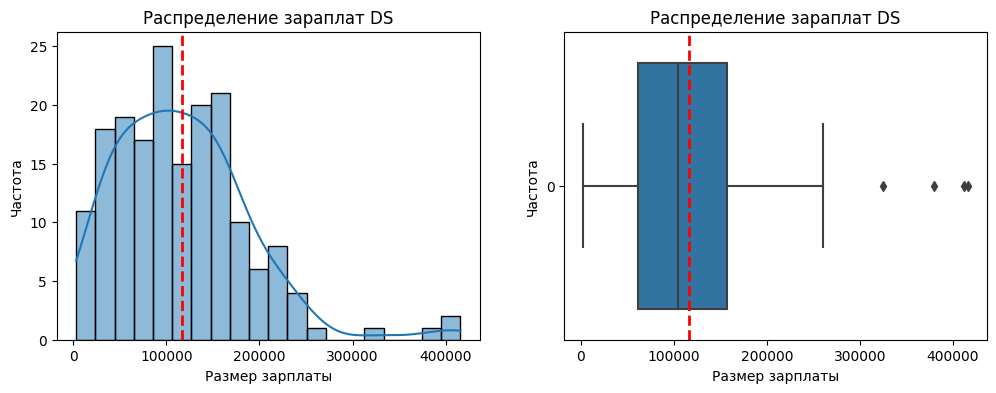

In [508]:
fig,axes=plt.subplots(1,2,figsize=(12,4))

sns.histplot(data[data['job']=='Data Scientist']['salary_in_usd'],kde=True,ax=axes[0],bins=20)
axes[0].set(xlabel='Размер зарплаты', ylabel='Частота')
axes[0].set_title('Распределение зараплат DS')
axes[0].axvline(data[data['job']=='Data Scientist']['salary_in_usd'].mean(),color='red',linestyle='--',linewidth=2);

sns.boxplot(data[data['job']=='Data Scientist']['salary_in_usd'], orient='h',ax=axes[1])
axes[1].set(xlabel='Размер зарплаты', ylabel='Частота')
axes[1].set_title('Распределение зараплат DS')
axes[1].axvline(data[data['job']=='Data Scientist']['salary_in_usd'].mean(),color='red',linestyle='--',linewidth=2);

In [509]:
ds_data_agg=data[data['job']=='Data Scientist']['salary_in_usd'].describe().round(2).to_frame()
ds_data_agg.columns=['Размер зарплат специалистов DS']
display(ds_data_agg)

,Размер зарплат специалистов DS
count,179.00
mean,116396.41
std,72362.48
min,2859.00
25%,62096.50
50%,105000.00
75%,157600.00
max,416000.00


### Зарплаты DS в зависимости от года

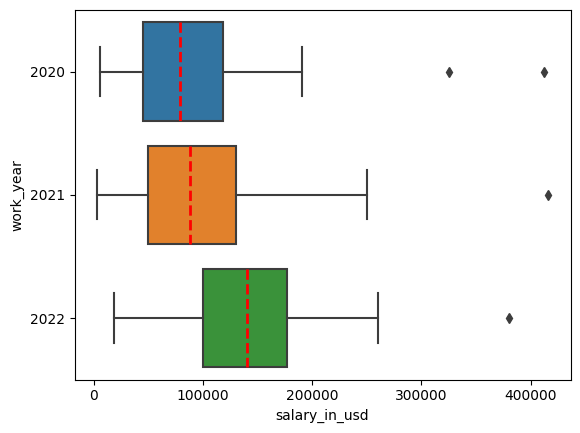

In [510]:
ax=sns.boxplot(
    data[data['job']=='Data Scientist'],
    x='salary_in_usd',
    y='work_year',
    orient='h',
    medianprops={'color':'red',
                 'linestyle':'--',
                 'linewidth':2})

In [511]:
ds_data_agg=data[data['job']=='Data Scientist'].groupby('work_year')['salary_in_usd'].describe().round(2)
display(ds_data_agg)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,28.0,102948.18,89203.03,5707.0,44869.25,78395.5,118500.0,412000.0
2021,73.0,96397.90,69450.25,2859.0,49646.00,87738.0,130026.0,416000.0
2022,78.0,139940.54,61627.85,18442.0,100000.00,140400.0,176750.0,380000.0


Разделения зарплат DS, судя по графику различны и таблице. Но рано судить о статистической значимости этих различий, только после статистического тестирования.

### Соотношение зарплат Data Scientist и Data Engineer в 2022 году

In [512]:
ds_de_data2022=data[(data['job'].notnull())&(data['work_year']==2022)]
ds_de_data2022

,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job
289,2022,SE,FT,135000,US,100,US,M,Data Engineer
292,2022,MI,FT,130000,US,0,US,M,Data Scientist
293,2022,MI,FT,90000,US,0,US,M,Data Scientist
294,2022,MI,FT,170000,US,100,US,M,Data Engineer
295,2022,MI,FT,150000,US,100,US,M,Data Engineer
...,...,...,...,...,...,...,...,...,...
593,2022,SE,FT,150000,US,100,US,M,Data Scientist
598,2022,MI,FT,160000,US,100,US,M,Data Scientist
599,2022,MI,FT,130000,US,100,US,M,Data Scientist
602,2022,SE,FT,154000,US,100,US,M,Data Engineer


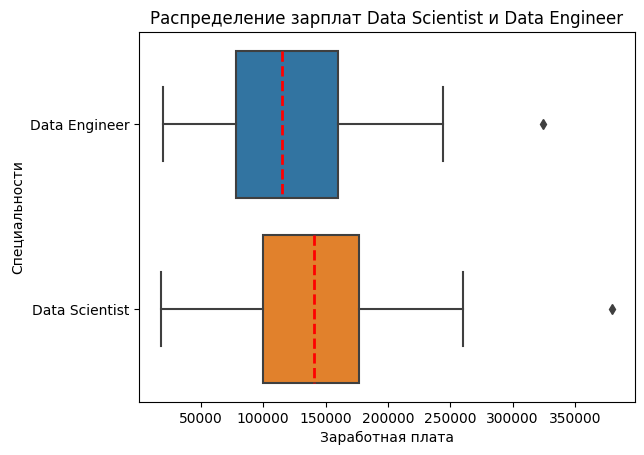

In [513]:
ax=sns.boxplot(ds_de_data2022,x='salary_in_usd',y='job', medianprops={'color':'red','linestyle':'--', 'linewidth':2})
ax.set_title('Распределение зарплат Data Scientist и Data Engineer')
ax.set(xlabel='Заработная плата',  ylabel='Специальности');

In [514]:
ds_de_data2022.groupby('job')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
job,,,,,,,,
Data Engineer,81.0,123279.98,58293.38,20000.0,78526.0,115000.0,160000.0,324000.0
Data Scientist,78.0,139940.54,61627.85,18442.0,100000.0,140400.0,176750.0,380000.0


В 2022 году заработные платы дата-сайентистов ощутимо больше зарплаты дата-инженеров и по медиане, и по среднему арифметическому.

### Соотношение зарплат специалистов Data Scientist в компаниях различных размеров?

C:\Users\user\AppData\Local\Temp\ipykernel_5272\1948476356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_data['company_size']=ds_data['company_size'].astype('category')
C:\Users\user\AppData\Local\Temp\ipykernel_5272\1948476356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_data['company_size']=ds_data['company_size'].cat.rename_categories({


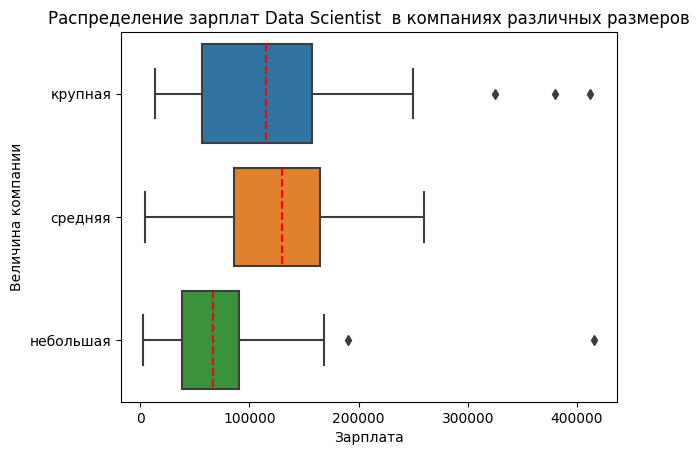

In [515]:
ds_data=data[data['job']=='Data Scientist']
ds_data['company_size']=ds_data['company_size'].astype('category')
ds_data['company_size']=ds_data['company_size'].cat.rename_categories({
    'S':'небольшая',
    'M':'средняя',
    'L':'крупная'
})
ax=sns.boxplot(ds_data,x='salary_in_usd',y='company_size',medianprops={'color':'red','linestyle':'--'})
ax.set_title('Распределение зарплат Data Scientist  в компаниях различных размеров')
ax.set(xlabel='Зарплата', ylabel='Величина компании');

In [516]:
ds_data.groupby('company_size')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
крупная,69.0,121955.77,80841.56,13400.0,56256.00,115000.0,157000.00,412000.0
средняя,82.0,124499.94,57571.25,4000.0,85425.75,130000.0,164418.50,260000.0
небольшая,28.0,78964.82,79917.35,2859.0,38030.75,66233.5,90309.25,416000.0


Визуально с небольшим отрывом от крупных компаний(более 250 сотрудников) лидируют компании средних размеров(от 50 до 250 сотрудников). А вот небольшие компании увы отстают.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании?

[Text(0.5, 0, 'Размер компании'), Text(0, 0.5, 'Количество компаний')]

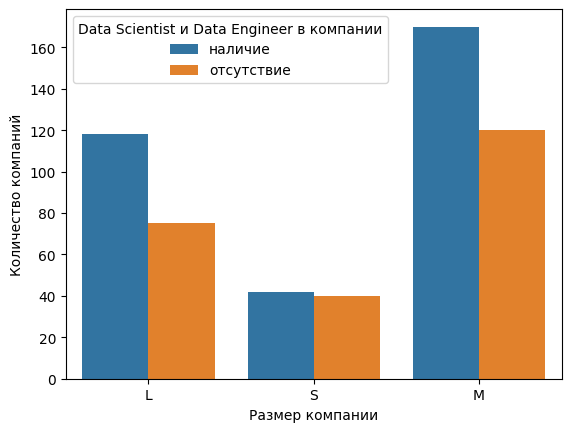

In [517]:
data['Data Scientist и Data Engineer в компании']=data['job'].apply(lambda x: 'наличие' if ((x=='Data Scientist') or (x=='Data Engineer')) else 'отсутствие')

ax=sns.countplot(data,x=data['company_size'],hue='Data Scientist и Data Engineer в компании')
ax.set(xlabel='Размер компании',ylabel='Количество компаний')

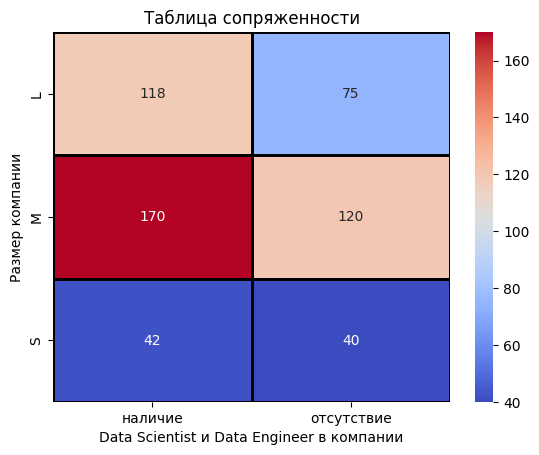

In [518]:
cross_tab=pd.crosstab(index=data['company_size'],columns=data['Data Scientist и Data Engineer в компании'])
ax=sns.heatmap(cross_tab, annot=True,fmt='.0f',cmap='coolwarm',linewidths=2,linecolor='black')
plt.title('Таблица сопряженности')
ax.set(ylabel='Размер компании');

Согласно данным таблицы компаний со специалистами Data Science и  Data Engineering больше, чем компаний без специалистов. Можно предположить, что компании со специалистами имеют больший потенциал вырасти, чем без специалистов Data Science и Data Engineering. Для определения статистической значимости различий, позднее проведем статистические тесты.

### Распределение зарплат Data Scietist по опыту работы

In [519]:
ds_data.loc[:,'experience_level']=ds_data.loc[:,'experience_level'].astype('category')
ds_data.loc[:,'experience_level']=ds_data.loc[:,'experience_level'].cat.rename_categories(
    {
        'EN':'Junior',
        'MI':'Intermediate',
        'SE':'Expert',
        'EX':'Director'
    }
)

ax=sns.boxplot(data=ds_data,
            x='salary_in_usd',
            y='experience_level',
            medianprops={
                'color':'red',
                'linestyle':'--',
                'linewidth':2});
ax.set_title('Распределение зарплат Data Scientist по опыту работы ')
ax.set(xlabel='Заработная плата', ylabel='Опыт работы');

AttributeError: Can only use .cat accessor with a 'category' dtype

In [ ]:
ds_data.groupby('experience_level')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
Junior,28.0,58590.04,32115.87,4000.0,34920.00,55198.0,87527.25,110037.0
Director,11.0,196375.82,103378.46,69741.0,135936.00,167875.0,237000.00,416000.0
Intermediate,68.0,87677.07,50927.20,2859.0,44869.25,81166.5,120586.50,241000.0
Expert,72.0,153781.42,65319.66,20171.0,114591.75,150000.0,180000.00,412000.0


Видно, что зарплата Data Scientist растут по мере опыта. Чтобы определить статистическую значимость этих различий, позже проведем тесты.

### Распределение зарплат Data Scientist по типу трудоустройства

C:\Users\user\AppData\Local\Temp\ipykernel_5272\1209916454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_data['employment_type']=ds_data['employment_type'].astype('category')
C:\Users\user\AppData\Local\Temp\ipykernel_5272\1209916454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_data['employment_type']=ds_data['employment_type'].cat.rename_categories(


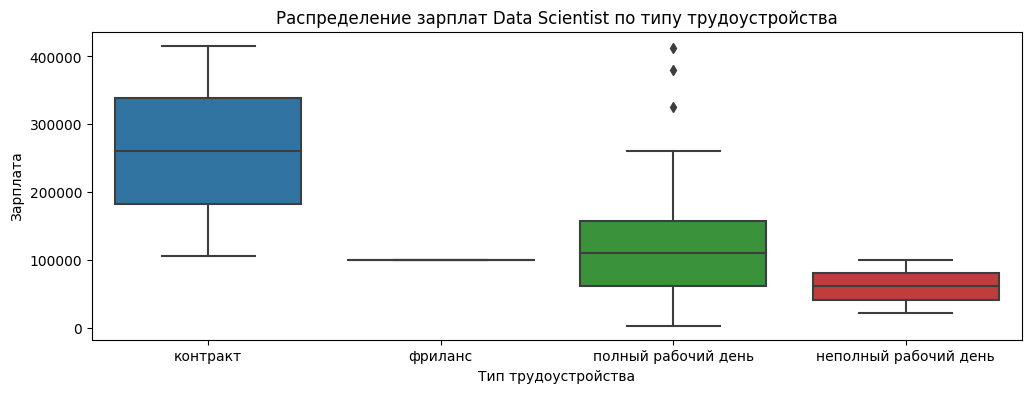

In [ ]:
ds_data['employment_type']=ds_data['employment_type'].astype('category')
ds_data['employment_type']=ds_data['employment_type'].cat.rename_categories(
    {
        'PT':'неполный рабочий день',
        'FT':'полный рабочий день',
        'CT':'контракт',
        'FL':'фриланс',
    }
)

fig,ax=plt.subplots(figsize=(12,4))
ax=sns.boxplot(ds_data,x='employment_type',y='salary_in_usd')
ax.set_title('Распределение зарплат Data Scientist по типу трудоустройства')
ax.set(xlabel='Тип трудоустройства',ylabel='Зарплата');

In [ ]:
ds_data.groupby('employment_type')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
контракт,2.0,260500.00,219910.21,105000.0,182750.00,260500.0,338250.00,416000.0
фриланс,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
полный рабочий день,174.0,115472.93,69370.20,2859.0,61781.75,109500.0,157900.00,412000.0
неполный рабочий день,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Согласно графику и таблице видно, то почти все Data Scientist'ы работают полный рабочий день. Не вижу смысла проводить статистические тесты из-за малого количества данных по всем типам трудоустройства, кроме полного рабочего дня. И поэтому считаю признак 'employment_type' неинформативным

In [520]:
del data['employment_type']

# Статистический анализ данных

In [ ]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Для ответа на вопрос сначала уберем данные, не касающиеся специалистов Data Scientist. 

Имеются 3 количественных независимых группы с нормальным распределением.

Сформулируем пулевую и альтернативную гипотезы

*Нулевая гипотеза* ($H_0$): размеры зарплат по годам не отличается

<center> m1=m2=m3 </center>

*Альтернативная гипотеза* ($H_1$): размеры зарплат по годам отличается

<center> m1!=m2!=m3 </center>

In [ ]:
from scipy import stats

year_2020=ds_data[ds_data['work_year']==2020]['salary_in_usd']
year_2021=ds_data[ds_data['work_year']==2021]['salary_in_usd']
year_2022=ds_data[ds_data['work_year']==2022]['salary_in_usd']
year_list=[year_2020,year_2021,year_2022]

#проводим тест на нормальность
for i in year_list:
    result=stats.shapiro(i)
    decision_normality(result[1])

_,p=stats.kruskal(year_2020,year_2021,year_2022)
print('По тесту Краскела \t p-value={:.3f}'.format(p))
result=decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
По тесту Краскела 	 p-value=0.000
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Тест показал на неравенство зарплат. Отсюда вывод, что необходимо провести 2 теста:
+ тест 2020 и 2021 годов;
+ тест 2021 и 2022 годов.

*Нулевая гипотеза* ($H_0$): зарплаты 2021 (m2) года меньше или равны зарплатам 2020 (m1) года и/или зарплаты 2022 года (m3) меньше или равны зарплатам 2021 года (m2). 

<center> m1 >= m2 </center>
<center> m2 >= m3 </center>

*Альтернативная гипотеза* ($H_1$): зарплата 2021 года (m2) больше зарплат 2020 года (m1), также зарплата 2022 (m3) года больше зарплат 2021 года (m2).

<center> m1 < m2 </center>
<center> m2 < m3 </center>

Если хоть один из тестов подтвердит нулевую гипотезу, альтернативная гипотеза будет отвергнута.

In [ ]:
#тест независимых данных с ненормальным распределением
print('Тест на 2020 и 2021 годы')
_,p=stats.mannwhitneyu(year_2021,year_2020,alternative='greater')
result=decision_hypothesis(p)

print('\nТест на 2021 и 2022 годы')
_,p=stats.mannwhitneyu(year_2022,year_2021,alternative='greater')
result=decision_hypothesis(p)


Тест на 2020 и 2021 годы
p-value = 0.455
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

Тест на 2021 и 2022 годы
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


***Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?*** Рост зарплат у специалистов Data Scientist наблюдался при сравнении 2021 и 2022 годов, однако отсутствовал при изучении 2020 и 2021 годов.

Вывод: нет оснований утверждать про ежегодный рост зарплат специалистов Data Scientist.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [ ]:
ds_de_data2022
de_2022=ds_de_data2022.loc[data['job']=='Data Engineer','salary_in_usd']
ds_2022=ds_de_data2022[ds_de_data2022['job']=='Data Scientist']['salary_in_usd']

[decision_normality(stats.shapiro(i)[1]) for i in [de_2022,ds_2022]]

p-value = 0.016
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


[None, None]

На графике "Распределение зарплат Data Scientist и  Data Engineer" зарплата Data Scientist больше. Проверим на статистических тестах.

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist (m2) меньше или равна зарплате Data Engineer (m1).

<center> m1 >= m2 </center>

*Альтернативная гипотеза* ($H_1$): зарплата Data Scientist (m2) больше зарплаты Data Engineer (m1).

<center> m1 < m2 </center>

Данные независимы и распределены ненормально.

In [ ]:
result=stats.mannwhitneyu(ds_2022,de_2022,alternative='greater')
decision_hypothesis(result[1])

p-value = 0.027
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: в 2022 году зарплаты Data Scientist больше зарплат Data Engineer.

## Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

*Нулевая гипотеза* ($H_0$): зарплаты Data Scientist не имеют разницу в зависимости от величины компании .

*Альтернативная гипотеза* ($H_1$): зарплаты Data Scientist имеют разницу в зависимости от величины компании.

In [ ]:
ds_data
s_size=ds_data.loc[ds_data['company_size']=='небольшая']['salary_in_usd']
m_size=ds_data.loc[ds_data['company_size']=='средняя']['salary_in_usd']
l_size=ds_data.loc[ds_data['company_size']=='крупная']['salary_in_usd']

[decision_normality(stats.shapiro(i)[1]) for i in [s_size,m_size,l_size]]
print()
decision_hypothesis(stats.kruskal(s_size,m_size,l_size)[1])


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
p-value = 0.785
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Принимаем альтернативную гипотезу, разница в зарплатах присутствует. Теперь посмотрим глубже. Будем отталкиваться от графика **"Распределение зарплат Data Scientist в компаниях различных размеров"**

Сравним отдельно:
+ небольшую и среднюю;
+ небольшую и крупную;
+ среднюю и крупную.

По каждой из трех групп запустим U-критерий Манна-Уитни
Нулевая гипотеза:
+ зарплаты в средней меньше или равна зарплате в небольшой;
+ зарплаты в крупной меньше или равна зарплате в небольшой;
+ зарплаты в средней меньше или равна зарплате в крупной;

Альтернативная гипотез:
+ зарплаты в средней больше, чем в небольшой;
+ зарплаты в крупной больше, чем в небольшой;
+ зарплаты в средней больше, чем в большой;


In [ ]:
decision_hypothesis(stats.mannwhitneyu(m_size,s_size,alternative='greater')[1])

decision_hypothesis(stats.mannwhitneyu(l_size,s_size,alternative='greater')[1])

decision_hypothesis(stats.mannwhitneyu(m_size,l_size,alternative='greater')[1])


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.145
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод: определенно, зарплаты Data Scientist зависят от размеров компании. В небольших компаниях (до 50 сотрудников) Data scientist зарабатывает меньше, чем в средних и крупных компаниях. Однако ж нет оснований утверждать, что зарплаты средних (от 50 до 250 сотрудников) компаний отличаются от зарплат крупных ( более 250 сотрудников) компаний.

## Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist (m2) меньше или равна зарплате Data Engineer (m1).

*Альтернативная гипотеза* ($H_1$): имеется связь между наличием должностей Data Scientist и Data Engineer и размером компании.

In [ ]:
table=pd.crosstab(data['company_size'],data['Data Scientist и Data Engineer в компании'])
_,p,_,_=stats.chi2_contingency(table)
decision_hypothesis(p)
display(table)

p-value = 0.310
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Data Scientist и Data Engineer в компании,наличие,отсутствие
company_size,,
L,118,75
M,170,120
S,42,40


Согласно критерию хи-квадрат связи между наличием должностей Data Scientist и Data Engineer нет.

## Распределение зарплат Data Scientist по опыту работы

*Нулевая гипотеза* ($H_0$): зарплаты Data Scientist не отличаются в зависимости от опыта работы.

*Альтернативная гипотеза* ($H_1$): зарплаты Data Scientist отличаются в зависимости от опыта работы.

In [ ]:
ds_data.loc[:,'experience_level']=ds_data.loc[:,'experience_level'].astype('object')
filter_data=ds_data.loc[:,['experience_level','salary_in_usd']]
experience_list=list(filter_data['experience_level'].unique())

for i in experience_list:
    need_data=filter_data[filter_data['experience_level']==i]['salary_in_usd']
    result=stats.shapiro(need_data)
    print('\nДля опыта работы {}'.format(i))
    decision_normality(result[1])


Для опыта работы Intermediate
p-value = 0.070
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для опыта работы Expert
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального

Для опыта работы Junior
p-value = 0.252
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным

Для опыта работы Director
p-value = 0.418
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [ ]:
data_intermediate=list(filter_data[ds_data['experience_level']=='Intermediate']['salary_in_usd'])
data_expert=list(filter_data[ds_data['experience_level']=='Expert']['salary_in_usd'])
data_junior=list(filter_data[ds_data['experience_level']=='Junior']['salary_in_usd'])
data_director=list(filter_data[ds_data['experience_level']=='Director']['salary_in_usd'])

_,p=stats.kruskal(data_intermediate,data_expert,data_junior,data_director)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Вывод: согласно статистическим тестам зарплаты Data Science отличаются в зависимости от опыта работы